**2021/22**

# Introduction to Apache Spark
In this lecture we will introduce the Spark framework. Right now, the goal is to explain how it works and to highlight its potentiality.

**Disclaimer**: Some content presented in this notebook e.g. images are based on references mentioned at the end of the notebook.

**Context** 

In the past, computers got faster mainly due to processor speed increases. And most of the applications were designed to run in a single processor machine. But as more data was required to be processed and hardware limits were being tested, research efforts moved towards parallel processing and new programming models. 

**Apache Spark** 
- is an open-source distributed cluster-computing framework. It is designed for large-scale distributed data processing, with focus on speed and modularity;
- provides in-memory storage for intermediate computations;
- contain libraries with APIs for machine learning, SQL, stream processing and graph processing.


# Spark components and APIs
Spark offers four components as libraries for diverse workloads in a unified stack.

Code can be written in the languages Scala, SQL, Python, Java or R, which then is decomposed into bytecode to be executed in Java Virtual Machines (JVMs) across the cluster.

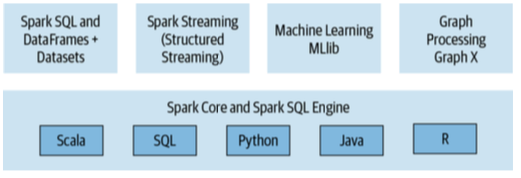

There are both low-level and high-level APIs related to (distributed) collections of data. We may have collections of:

* **Resilient Distributed Dataset (RDD)**
    * they are now consigned to low-level APIs
* **DataFrame**
    * the most commom structured data - it simply represents a table of data with rows and columns
* **Dataset**
    * collection of objects but only makes sense in the case of Scala and Java 

Further details are to be covered later on but we can highlight now that our focus will be on **DataFrames**

## Spark Core and Spark SQL Engine
Spark Core contains basic functionalities for running jobs and that are needed by other components. Spark SQL Engine provides additional help to do so.

Computations will ultimatelly convert into low-level RDD-based bytecode (in Scala) to be distributed and run in executors across the cluster.

## Spark SQL
Spark SQL provides functions for manipulating large sets of distributed structured data using an SQL subset. (ANSI SQL:2003-compliant)

It can also be used for **reading** and **writing** data to and from various structured formats and data sources, such as JavaScript Object Notation (JSON) files, CSV files, Parquet files (an increasingly popular file format that allows for storing a schema alongside the data), relational databases, Hive, and others.  
  
There is also a query optimization framework called Catalyst.

## Spark Structured Streaming
Spark Structured Streaming is a framework for ingesting real-time streaming data from various sources, such as HDFS-based, Kafka, Flume, Twitter, ZeroMQ, as well as customized ones. 

Developers are able to combine and react in real time to both static and streaming data. A stream is perceived as a continuaslly growing structured table, upon against which queries are made as if it was a static table.

Aspects of fault tolerance and late-data semantics are handled via Spark SQL core engine. Hence, developers are focussing on just writing streaming applications. 

## Machine Learning MLlib
Spark MLlib is a library of common machine-learning (ML) algorithms built on top of DataFrame-based APIs. Among other aspects, these APIs allow to extract or transform features, build pipelines (for training and evaluating) and persist models during deployment (for saving/reloading)

Available ML algorithms include logistic regression, naïve Bayes classification, support vector machines (SVMs), decision trees, random  forests, linear regression, k-means clustering, among others. 

## Graph Processing GraphX
Spark Graphx is a library for manipulating graphs, that is, data  structures  comprising  vertices  and  the  edges  connecting  them. 

It provides  algorithms for building, analysing, connecting and traversing graphs. Among others, there are implementations of important algorithms of graph theory, such as page rank, connected components, shortest paths and singular value decomposition. (SVD)

# Execution in a distributed architecture
A **Spark Application** consists of a **driver** program responsible for orchestrating parallel operations on the Spark cluster. The driver accesses the distributed components in the cluster (**executors** and **manager**) via a **SparkSession**. 

## SparkSession
A SparkSession instance provides a single entry point to all functionalities.

For a Spark application, one needs to create the SparkSession object if none is available, as described below. In that case, we can configure it according to ower own needs.

But first, we have to make sure we can access **pyspark** from this notebook. One way to do so is to run the notebook using use a suitable kernel. That is why we have already set one: **PySpark**.

For the time being there is no need to provide furter details about this kernel - it is just a file named *kernel.json* placed in a proper location and with some settings.

In [ ]:
from pyspark.sql import SparkSession

# build our own SparkSession
myspark = SparkSession\
    .builder\
    .appName("BigData")\
    .config("spark.sql.shuffle.partitions",6)\
    .config("spark.sql.repl.eagereval.enabled",True)\
    .getOrCreate()

In [ ]:
# check it, including the link


In [ ]:
# print SparkSession object


In [ ]:
# Example of usage:
# creating a range of numbers, represented as a distributed collection
numbers_to_n = myspark.range(1000000).toDF("Number")

## Cluster manager and executors

* **Cluster manager**
    * responsible for managing the executors in the cluster of nodes on which the application runs, alongside allocating the requested resources
    * agnostic where ir runs as long as responsabilities above are met
* **Spark executor**
    * runs on each worker node in the cluster
    * executors communicate with driver program and are responsible for executing tasks on the workers

* **Deployment modes**

    * variety of configurations and environments available, as shown below: (just for reference)

    
| Mode           | Spark driver                                       | Spark executor | Cluster manager |
|:----------------|:----------------------------------------------------|:----------------|:-----------------|
| Local          | Runs on a single JVM, like a laptop or single node | Runs on the same JVM as the driver              | Runs on the same host               |
| Standalone     | Can run on any node in the cluster                                               | Each node in the cluster will launch its own executor            | Can be allocated arbitrarily to any host in the cluster             |
| YARN (client)  | Runs on a client, not part of the cluster                                                | YARN's NodeManager's container            | YARN's Resource Manager works with YARN's Application Master to allocate the containers on NodeManagers for executors             |
| YARN (cluster) | Runs with the YARN Application Master                                                | Same as YARN client mode            | Same as YARN client mode        |
| Kubernetes     | Runs in a Kubernetes pod                                          | Each worker runs within its own pod       | Kubernetes Master         |
    

## Distributed data and partitions

* Partitioning of data allows for efficient paralelism since every executor can perform work in parallel
* Physical data is break up and distributed across storage as chunks called partitions, whether in HDFS or in cloud storage.
* Each partition is treated as a dataframe in memory (logical data abstraction)
    * hence it is a collection of rows that sits on one physical machine of the cluster;
    * so if we have dataframes in our program we do not (for the most part) manipulate partitions individually - we simply specify high level transformations of data in the physical partitions, and Spark determines how this will play out across the cluster.
* As much as possible, data locality is to be pursuit. It means that an executor is prefereably allocated a task that requires reading a partition closest to it in the network in order to minimize network bandwidth.

**Question**: What happens if we have
* multiple partitions but only one executor;
* one partition but thousands of executors?


# Standalone application running in local mode
Conceptually, we prototype the application by running it locally with small datasets; then, for large datasets, we use more advanced deployment modes to take advantage of distributed and more powerful execution.

## Spark shells

Spark provides four interpretative shells (windows) to carried out ad hoc data analysis:
* pyspark
* spark-shell
* spark-sql
* sparkR

They resemble their shell counterparts for the considered languages. The main difference now is that they have extra support for connecting to the cluster and to loading distributed data into worker's memory

Notice that, if using shells:
* the driver is part of the shell
* the SparkSession mentioned above is automatically created, accessible via the variable `spark`
* they are exited pressing Ctrl-D

Note: in accordance to the location of the Spark installation in our computer, we have set for the shell (terminal window) the following environment variables (in the file ~/.profile) 

    export SPARK_HOME=/opt/spark

    export PATH=$PATH:$SPARK_HOME/bin:$SPARK_HOME/sbin

    export PYSPARK_PYTHON=/usr/bin/python3
    
    
By the way, in Linux the command `which` is useful for checking where programms are installed.

In [ ]:
# run pyspark

**Stop running the previous cell. Here we can't do that much!**

## Example running in a `pyspark` shell
Reading a file and then showing top 10 lines, as well as the number of lines. It runs locally, in a single JVM.

First, open an autonomous shell (Terminal window) and run the following commands, one by one:

    which pyspark
    pyspark --help
    pyspark
    spark.version
    2+3

And then execute the commands (the provided file is located in the current directory)

    lines = spark.read.text("pyspark-help.txt")
    lines.show(10, truncate=False)
    lines.count()
    quit()

# Spark operations and related computation
Operations on distributed data are of two types: **transformations** and **actions**

## Basic concepts

* **Job**: parallel computation created by the driver, consisting of multiple tasks that gets spawned in response to actions, e.g save()
* **Stage**: each job gets divided into smaller sets of tasks called stages, that depend on each other
* **Task**: single unit of work or execution to be sent to a Spark executor (a task per core)



 ## Transformations
 
In Spark core data structures are **Immutable**, that is, they cannot be changed after creation. If one wants to change a dataframe we need to instruct Spark how to do it. These are called transformations.
 
Hence, transformations transform a DataFrame into a new one without altering the original data. So it returns a new one but transformed.

Some examples are:

|Transformation | Description|
|:-------|:-------|
|**orderBy()**|Returns a new DataFrame sorted by specific column(s)|
|**groupBy**|Groups the DataFrame using specified columns, so we can run aggregation on them|
|**filter()**|Filters rows using a given condition|
|**select()**|Returns a new DataFrame with select columns|
|**join()**|Joins with another DataFrame, using a given join expression|

**Back to our myspark session...**

Checking the content of a text file.

In [ ]:
# strings = 

In [ ]:
# filtering lines with a particular word, say pyspark
# filtered =

### Types of transformations

Transformations can be:
* Narrow
    * a single output partition can be computed from a single input partition (no exchange of data, all performed in memory)
    * examples are **filter()**, **contains()**
* Wide
    * data from other partitions across the cluster is read in, combined, and written to disk
    * examples are **groupBy()**, **reduceBy()**


### Example

**Reading structured data, filter some of them and then show the result but sorted**

(The file is on the same folder as this notebook)

In [ ]:
# Prior, just let us check the file we are about to use (with help of Linux commands)
! ls -la
! head flights-US-2015.csv

In [ ]:
# Read the datafile into a DataFrame using the CSV format, 
# by inferring the schema and specifying that the file contains a header,
# which provides column names for comma-separated fields

# info_flights = 

# info_flights  # or print(info_flights)

In [ ]:
# check how many records we have in the DataFrame


In [ ]:
# and showing some of them


In [ ]:
# get routes from the United States

# and try other options ...

In [ ]:
# show the routes


 ## Lazy evaluation and actions
 
Spark uses lazy evaluation, that is, it waits until the very last moment to execute the graph of computational instructions established, that is, the plan of transformations that we would like to apply to the data.

As results are not computed immediately, they are recorded as **lineage** (*trace of descendants*) and at later time in its execution plan, Spark may rearrange certain transformations, coalesce them, or optimize transformations into stages for more efficient execution of the entire flow.
 
Only when an **action** is invoked or data is read/written to disk the lazy evaluation of all recorded transformations is triggered.

An action is like a play button. We may have:
* Actions to view data in the console.
* Actions to collect data to native objects in the respective language.
* Actions to write to output data sources.

Some examples are:

|Action | Description|
|:-------|:-------|
|**show()**|Prints the first rows to the console|
|**take(n)**|Returns the first rows as a list|
|**count()**|Returns the number of rows|
|**collect()**|Returns all the records as a list|
|**save()**|Saves the contents to a data source|

In [ ]:
# Using the variable numbers_to_n (a DataFrame) set before...
even_numbers = numbers_to_n.where("number % 2 = 0") # why didn't return the output?

In [ ]:
even_numbers.explain() # or even_numbers.explain(extended=True)

In [ ]:
# count


In [ ]:
# get 5 of them


In [ ]:
# the 1st one


In [ ]:
# and show


## Fault tolerance
**Lineage** in the context of lazy evaluation and **data immutability** mentioned above gives resiliency in the event of failures as:
* Spark records each transformation in its lineage;
* DataFrames are immutable between transformations;

then Spark can reproduce the original state by replaying the recorded lineage.

## Spark UI
Spark UI allow us to monitor the progress of a job. It displays information about the state of Spark jobs, its environment and the cluster state. So it is very useful for tuning and debugging.
 
Usually Spark UI is available on port 4040 of the driver node. (If that port is occupied, another one is provided)

In local mode: http://localhost:4040 in a web browser.


    PS: recall notebook cell above when myspark was checked.

In [ ]:
myspark.sparkContext.uiWebUrl # check where spark ui is running

Check the link presented above after execution.

In [ ]:
# Let us stop the SparkSession
myspark.stop()

# Exercise

Our goal now is to write down a Spark program that (i) reads a file containing flight data to and from United States and then (ii) provide answers to the following questions about the data that has been just read:

1. How many records exist in the dataset?
2. How many routes originate in countries with more than one?
3. Give the number of flights in the busiest route?
4. Which countries are the top 5 destinations? (by number of flights)

## The Spark program

In [ ]:
# Import the necessary libraries
import sys
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, max, sum

In [ ]:
# Build a SparkSession using the SparkSession APIs. If it does not exist one, then create an instance.
# Notice that we can only have one per JVM
myspark = SparkSession\
          .builder\
          .appName("Flights")\
          .config("spark.sql.repl.eagereval.enabled",True)\
          .getOrCreate()

# alternatively we could have written
# myspark = (SparkSession
#          .builder
#          .appName("Flights")
#          .getOrCreate())
# or
# spark = SparkSession.builder.appName("Flights").getOrCreate())

As before, we are using DataFrame high-level APIs (Spark SQL could also have been used here but we leave it for the time being)

In [ ]:
# read the dataset

# flight_data = 

In [ ]:
# First, let us check the schema and the initial lines of the dataset. 
# We should always take this step

# flight_data.printSchema()
# flight_data.show(5)

In [ ]:
# Just a detail: to figure out how, for example, sorting by FLIGHTS would work
# flight_data.sort("FLIGHTS").explain() # check the Spark physical plan

**Before moving on, a note about reading data from a csv file:**

Above, we have inferred the schema from the first line of the csv file. And by the way reading is a transformation not an action.

But we could have set the schema programatically and then read the data from the file accordingly. When schema is inferred from a huge file this may take some time. So in those circunstances we may decide to set the schema programmatically. 

## Questions to be answered

In [ ]:
# 1. How many records exist in the dataset?


In [ ]:
# 2. How many routes originate in countries with more than one?


In [ ]:
# 3. Give the number of flights in the busiest route?


In [ ]:
# 4. Which countries are the top 5 destinations? (by number of flights)
# top_dest_countries_df = flight_data\
              
               
# show the results. As it is an action, it triggers the above query to be executed


# print("Total = %d" % (top_dest_countries_df.count()))

In [ ]:
# Finally, stop the SparkSession
myspark.stop()

# Additional exercises
The Spark distribution comes with a few examples. We ask you to look at the directory 

*/opt/spark/examples/src/main/python* 

and try to run the following examples but in a notebook: (minor adjustments might be needed)

1. wordcount
2. sort

# References

* Learning Spark - Lightning-Fast Data Analytics, 2nd Ed. J. Damji, B. Wenig, T. Das, and D. Lee. O'Reilly, 2020
* Spark: The Definitive Guide - Big Data Processing Made Simple, 1st Ed. B. Chambers and M. Zaharia. O'Reilly, 2018
* https://spark.apache.org/docs/latest
* https://docs.python.org/3/